In [1]:
# Import libs
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
import os 
from tqdm.notebook import tqdm 

import torch 
from torch import nn 
import torch.nn.functional as F 
from torch import optim 
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary

from sklearn.metrics import mean_squared_error
import datetime

# Data preparation

## Combine 2 datasets together

In [2]:
stations = ['76t', '36t', '75t']

In [3]:
station_to_file = {
    '76t': 'data/PCD Data/Data before 2020-9/(76t)ศูนย์การศึกษานอกโรงเรียน จ.ตาก.xlsx',
    '36t': 'data/PCD Data/Data before 2020-9/เชียงใหม่/(36t)โรงเรียนยุพราชวิทยาลัย.xlsx',
    '75t': 'data/PCD Data/Data before 2020-9/น่าน/(75t)โรงพยาบาลเฉลิมพระเกียรติ จ.น่าน.xlsx'
    }
sheets = {
    '76t': 0,
    '36t': 2,
    '75t': 1
}

In [4]:
dfs1 = {}
for station in stations:
    dfs1[station] = pd.read_excel(station_to_file[station], sheet_name=sheets[station])

In [5]:
dfs1['75t'].head()

,ปี/เดือน/วัน,ชั่วโมง,CO,NO2,SO2,O3,PM2.5,PM10,WS,WD,TEMP,RH
0,NaN,NaN,at 3 m (ppm),at 3 m (ppb),at 3 m (ppb),at 3 m (ppb),at 3 m (มคก./ลบ.ม.),at 3 m (มคก./ลบ.ม.),at 10 m (m/s),at 10 m (Deg.M),at 3 m,at 3 m (%RH)
1,160101.0,100.0,0,0,1,0,9,16,0.2,299,16,98
2,160101.0,200.0,0,0,1,0,9,17,0.2,276,15.8,99
3,160101.0,300.0,0,0,1,1,9,14,0.3,325,16.2,99
4,160101.0,400.0,0,0,0,2,10,13,0.2,224,15.9,100


In [6]:
dfs1['75t'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41641 entries, 0 to 41640
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ปี/เดือน/วัน  41640 non-null  float64
 1   ชั่วโมง       41640 non-null  float64
 2   CO            38372 non-null  object 
 3   NO2           41030 non-null  object 
 4   SO2           41023 non-null  object 
 5   O3            39381 non-null  object 
 6   PM2.5         40700 non-null  object 
 7   PM10          41430 non-null  object 
 8   WS            41472 non-null  object 
 9   WD            41473 non-null  object 
 10  TEMP          41473 non-null  object 
 11  RH            41473 non-null  object 
dtypes: float64(2), object(10)
memory usage: 3.8+ MB


In [7]:
def process_data_before(df):
    df = df.iloc[1:,:]
    df = df.rename(columns=lambda x: x.strip())
    df = df.loc[:, df.columns.isin(['PM2.5', 'ปี/เดือน/วัน', 'ชั่วโมง'])]
    df['Date'] = pd.to_datetime(df['ปี/เดือน/วัน'], format='%y%m%d')
    df['ชั่วโมง'] = df['ชั่วโมง'].apply(lambda x: 0 if int(x) == 2400 else x)
    df.loc[df['ชั่วโมง'] == 0, 'Date'] += datetime.timedelta(days=1)
    df['Time'] = df['ชั่วโมง'].astype('str')
    df['Time'] = df['Time'].apply(lambda x: x[:-2].zfill(4))
    df['Datetime'] = pd.to_datetime(df['Date'].astype('str') + ' ' +df['Time'], format='%Y-%m-%d %H%M')
    df = df.drop(['Time', 'Date', 'ปี/เดือน/วัน', 'ชั่วโมง'], axis=1)
    df = df.set_index('Datetime').sort_index()
    df = df[df.index < '2020-07-20 19:00:00']
    df = df[df.index > '2016-06-01 00:00:00']
    df['PM2.5'] = df['PM2.5'].replace('-', np.nan)
    return df

In [8]:
process_data_before(dfs1['75t']).head()

,PM2.5
Datetime,
2016-06-01 01:00:00,3.0
2016-06-01 02:00:00,NaN
2016-06-01 03:00:00,NaN
2016-06-01 04:00:00,NaN
2016-06-01 05:00:00,2.0


In [9]:
df2 = pd.read_csv('data/PCD Data/Data after 2020-7/PCD data after 2020-7.csv')

In [10]:
dfs2 = {}
for station in stations:
    dfs2[station] = df2[df2['stationID'] == station]

In [11]:
dfs2['75t'].head()

,id,stationID,nameTH,nameEN,stationType,lat,long,date_aq,time_aq,PM25,PM10,NO2,SO2,CO,O3,AQI,areaTH,areaEN,datetime_aq
10,515464,75t,โรงพยาบาลเฉลิมพระเกียรติ,Chalermprakiet Hospital,GROUND,19.32238,101.025365,2020-07-20,21:00:00,6.0,19.0,3.0,NaN,NaN,NaN,1,"ต.ห้วยโก๋น อ.เฉลิมพระเกียรติ, น่าน","Huai Kon, Chaloem Phra Kiat, Nan",2020-07-20 21:00:00.000
97,515593,75t,โรงพยาบาลเฉลิมพระเกียรติ,Chalermprakiet Hospital,GROUND,19.32238,101.025365,2020-07-20,22:00:00,6.0,19.0,2.0,1.0,NaN,NaN,1,"ต.ห้วยโก๋น อ.เฉลิมพระเกียรติ, น่าน","Huai Kon, Chaloem Phra Kiat, Nan",2020-07-20 22:00:00.000
235,515722,75t,โรงพยาบาลเฉลิมพระเกียรติ,Chalermprakiet Hospital,GROUND,19.32238,101.025365,2020-07-20,23:00:00,6.0,19.0,2.0,1.0,NaN,NaN,1,"ต.ห้วยโก๋น อ.เฉลิมพระเกียรติ, น่าน","Huai Kon, Chaloem Phra Kiat, Nan",2020-07-20 23:00:00.000
404,515206,75t,โรงพยาบาลเฉลิมพระเกียรติ,Chalermprakiet Hospital,GROUND,19.32238,101.025365,2020-07-20,19:00:00,6.0,19.0,3.0,1.0,NaN,NaN,1,"ต.ห้วยโก๋น อ.เฉลิมพระเกียรติ, น่าน","Huai Kon, Chaloem Phra Kiat, Nan",2020-07-20 19:00:00.000
522,515335,75t,โรงพยาบาลเฉลิมพระเกียรติ,Chalermprakiet Hospital,GROUND,19.32238,101.025365,2020-07-20,20:00:00,6.0,19.0,5.0,1.0,NaN,NaN,1,"ต.ห้วยโก๋น อ.เฉลิมพระเกียรติ, น่าน","Huai Kon, Chaloem Phra Kiat, Nan",2020-07-20 20:00:00.000


In [12]:
def process_data_after(df):
    df = df.drop(['id', 'stationID', 'nameTH', 'nameEN', 'stationType', 'lat', 'long', 'date_aq', 'time_aq', 'PM10', 'NO2', 'SO2', 'CO', 'O3', 'AQI','areaTH', 'areaEN'], axis=1)
    df['Datetime'] = pd.to_datetime(df['datetime_aq'], format='%Y-%m-%d %H:%M:%S.%f')
    df = df.set_index('Datetime').sort_index()
    df = df.rename(columns={'PM25': 'PM2.5'})
    df = df.drop(['datetime_aq'], axis=1)
    return df

In [13]:
process_data_after(dfs2['75t']).head()

,PM2.5
Datetime,
2020-07-20 19:00:00,6.0
2020-07-20 20:00:00,6.0
2020-07-20 21:00:00,6.0
2020-07-20 22:00:00,6.0
2020-07-20 23:00:00,6.0


In [14]:
dfs = {}
for station in stations:
    dfs[station] = pd.concat((process_data_before(dfs1[station]), process_data_after(dfs2[station])))

In [15]:
dfs['75t']

,PM2.5
Datetime,
2016-06-01 01:00:00,3.0
2016-06-01 02:00:00,NaN
2016-06-01 03:00:00,NaN
2016-06-01 04:00:00,NaN
2016-06-01 05:00:00,2.0
...,...
2022-01-30 14:00:00,23.0
2022-01-30 15:00:00,23.0
2022-01-30 16:00:00,22.0


## Impute missing value

In [16]:
for station in stations:
    dfs[station] = dfs[station].ffill()

## Add feature

In [17]:
for station in stations:
    # dfs[station]['Monthcos'] = np.cos(2 * np.pi * (dfs[station].index.month -1) /11)
    # dfs[station]['Monthsin'] = np.sin(2 * np.pi * (dfs[station].index.month -1) /11)

    dfs[station]['Hourcos'] = np.cos(2 * np.pi * dfs[station].index.hour/24)
    dfs[station]['Hoursin'] = np.sin(2 * np.pi * dfs[station].index.hour/24)

    dfs[station]['Weekcos'] = np.cos(2 * np.pi * (dfs[station].index.isocalendar().week - 1)/52)
    dfs[station]['Weeksin'] = np.sin(2 * np.pi * (dfs[station].index.isocalendar().week - 1)/52)


## Add timestep

In [18]:
def add_timestep(df, timestep):
    xs = []
    ys = []
    for i in range(df.shape[0]-timestep-1):
        x = df.iloc[i:i+timestep, :].to_numpy()
        y = df.iloc[i+timestep, 0]
        xs.append(x.astype(np.float32))
        ys.append(y.astype(np.float32))
    return xs, ys

In [19]:
class PMDataset(Dataset): 
  def __init__(self, xs, ys):
    self.xs = np.array(xs)
    self.ys = np.array(ys).reshape(-1,1)
  
  def __len__(self):
    return len(self.xs)
  
  def __getitem__(self, idx): 
    x = self.xs[idx]
    y = self.ys[idx]
    return x, y

In [20]:
def df_to_dataset(df, timestep, batch_size):
    xs, ys = add_timestep(df, timestep)
    dataset = PMDataset(xs, ys)
    return DataLoader(dataset, batch_size, shuffle=False, pin_memory=True)

In [21]:
train_dataloaders = {}
val_dataloaders = {}
test_dataloaders = {}
time_step = 24
batch_size = 32
for station in stations:
    temp = dfs[station]
    train = temp[temp.index < '2019-06-01']
    val = temp[('2019-06-01' <= temp.index) & (temp.index < '2020-06-01')]
    test = temp[temp.index >= '2020-06-01']
    train_dataloaders[station] = df_to_dataset(train, time_step, batch_size)
    val_dataloaders[station] = df_to_dataset(val, time_step, batch_size)
    test_dataloaders[station] = df_to_dataset(test, time_step, batch_size)


# Model

## Initialize model

In [22]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [23]:
class PMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_layers, device, drop_prob=0.2):
        super().__init__()
        
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.device = device

        self.gru = nn.GRU(input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)
        self.fc = nn.Linear(hidden_dim, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        h = torch.zeros(size=(self.n_layers, len(x), self.hidden_dim)).to(device)
        y, _ = self.gru(x, h)
        y = self.fc(y[:, -1])
        y = self.relu(y)
        return y


In [24]:
input_dim = dfs['76t'].shape[1]
hidden_dim = 512
n_layers = 5

pm_model = PMModel(input_dim, hidden_dim, n_layers, device)
pm_model = pm_model.to(device)

In [25]:
temp_time_step = 12
summary(pm_model, input_size=(batch_size,temp_time_step,input_dim))

Layer (type:depth-idx)                   Output Shape              Param #
PMModel                                  --                        --
├─GRU: 1-1                               [32, 12, 512]             7,100,928
├─Linear: 1-2                            [32, 1]                   513
├─ReLU: 1-3                              [32, 1]                   --
Total params: 7,101,441
Trainable params: 7,101,441
Non-trainable params: 0
Total mult-adds (G): 2.73
Input size (MB): 0.01
Forward/backward pass size (MB): 1.57
Params size (MB): 28.41
Estimated Total Size (MB): 29.99

In [26]:
criterion = nn.MSELoss()
optimizer = optim.Adam(pm_model.parameters(), lr=5e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=4, factor=0.1, min_lr=1e-8)

## Training

In [27]:
station = '75t'

In [27]:
num_epochs = 25

train_losses = []
val_losses = []
min_val_loss = float('inf')


os.makedirs('weights', exist_ok=True)
best_weights_path = f'weights/{station}_best_weights.pth'

for epoch in tqdm(range(num_epochs)):
    pm_model.train()
    total_train_loss = 0

    for x, y in train_dataloaders[station]:
        x = x.type(torch.FloatTensor).to(device)
        y = y.type(torch.FloatTensor).to(device)
        pm_model.zero_grad()

        out = pm_model(x)
        train_loss = criterion(out, y)
        train_loss.backward()
        optimizer.step()

        total_train_loss += train_loss.item()

    current_train_loss = total_train_loss / len(train_dataloaders[station])
    train_losses.append(current_train_loss)

    total_val_loss = 0
    pm_model.eval()
    with torch.no_grad():
        for val_x, val_y in val_dataloaders[station]:
            val_x = val_x.to(device)
            val_y = val_y.to(device)
            val_out = pm_model(val_x)

            val_loss = criterion(val_out, val_y)
            total_val_loss += val_loss.item()

    current_val_loss = total_val_loss / len(val_dataloaders[station])
    val_losses.append(current_val_loss)
    if current_val_loss < min_val_loss: 
        min_val_loss = current_val_loss 
        torch.save(pm_model.state_dict(), best_weights_path)
    print(f'Epoch {epoch+1} - Train loss = {current_train_loss:.4f} - Val loss = {current_val_loss:.4f} - best min_val_loss = {min_val_loss:.4f} - lr = {optimizer.param_groups[0]["lr"]:.8f}') 
    scheduler.step(current_val_loss)

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1 - Train loss = 672.4648 - Val loss = 1568.5105 - best min_val_loss = 1568.5105 - lr = 0.00005000
Epoch 2 - Train loss = 544.6089 - Val loss = 1364.0265 - best min_val_loss = 1364.0265 - lr = 0.00005000
Epoch 3 - Train loss = 475.3439 - Val loss = 1250.3844 - best min_val_loss = 1250.3844 - lr = 0.00005000
Epoch 4 - Train loss = 425.2002 - Val loss = 1163.1298 - best min_val_loss = 1163.1298 - lr = 0.00005000
Epoch 5 - Train loss = 386.8607 - Val loss = 1093.1821 - best min_val_loss = 1093.1821 - lr = 0.00005000
Epoch 6 - Train loss = 356.1255 - Val loss = 1035.2488 - best min_val_loss = 1035.2488 - lr = 0.00005000
Epoch 7 - Train loss = 330.3906 - Val loss = 987.2362 - best min_val_loss = 987.2362 - lr = 0.00005000
Epoch 8 - Train loss = 308.9354 - Val loss = 945.9108 - best min_val_loss = 945.9108 - lr = 0.00005000
Epoch 9 - Train loss = 290.5046 - Val loss = 907.6394 - best min_val_loss = 907.6394 - lr = 0.00005000
Epoch 10 - Train loss = 274.2485 - Val loss = 873.7011 - best

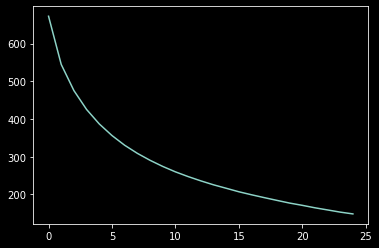

In [28]:
plt.plot(train_losses)
plt.show()

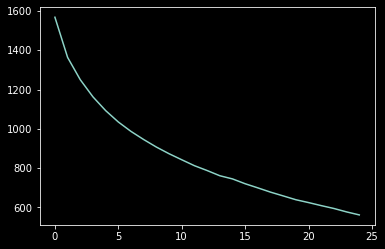

In [29]:
plt.plot(val_losses)
plt.show()

## Evaluate

In [28]:
best_weights_path = f'weights/{station}_best_weights.pth'
pm_model.load_state_dict(torch.load(best_weights_path))

<All keys matched successfully>

In [29]:
pm_model.eval()
y_preds = np.array([])
y_true = np.array([])
with torch.no_grad():
    for x, y in test_dataloaders[station]:
        x = x.to(device)
        y_pred = pm_model(x)
        y_preds = np.concatenate((y_preds, y_pred.detach().cpu().numpy().flatten()))
        y_true = np.concatenate((y_true, y.numpy().flatten()))


In [30]:
np.sqrt(mean_squared_error(y_true, y_preds))

3.231630035227534

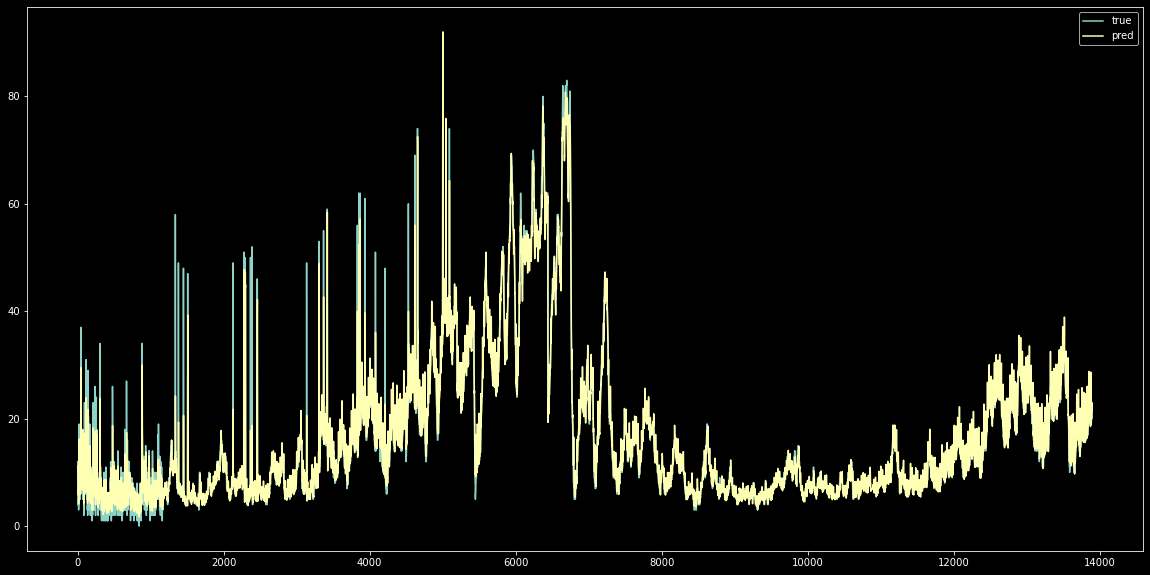

In [31]:
plt.figure(figsize=(20,10))
x = np.arange(0, len(y_true))
plt.plot(x, y_true, label='true')
plt.plot(x, y_preds, label='pred')
plt.legend()
plt.show()

## Upload predict data

In [32]:
temp = dfs[station]
test = temp[temp.index >= '2020-06-01']

In [36]:
out_pred_time = pd.DataFrame((test.iloc[25:, :].index))
out_pred = pd.concat((out_pred_time, pd.Series(y_preds)), axis=1)
out_pred = out_pred.rename({0: 'PM2.5'}, axis=1)

In [37]:
out_pred

,Datetime,PM2.5
0,2020-06-02 01:00:00,11.120969
1,2020-06-02 02:00:00,11.024005
2,2020-06-02 03:00:00,9.922991
3,2020-06-02 04:00:00,7.851151
4,2020-06-02 05:00:00,6.528430
...,...,...
13894,2022-01-30 14:00:00,22.813528
13895,2022-01-30 15:00:00,21.302158
13896,2022-01-30 16:00:00,22.024620
13897,2022-01-30 16:00:00,22.039042


In [35]:
out_pred.to_csv(f'{station}_prediction.csv', index=False)